Program overhead: load modules (and reload them as they are modified)

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import HW04_utils as ut
import numpy as np
from scipy import special as spsp
from matplotlib import pyplot as plt

Next, we give a couple paths specifying where to find the data set on the local machine. **A user must change this to reflect the path to their data.**

In [4]:
DATA_DIR = "/Users/mitch/Documents/Cal/2_2017_Spring/COMPSCI 289A - Intro to Machine Learning/HW04/Data/"
DATA_NAME = "data.mat"

Then, load the data using the custom utilities module:

In [5]:
descriptions = ut.loaddata(DATA_NAME,DATA_DIR,'description')
X = ut.loaddata(DATA_NAME,DATA_DIR,'X')
y = ut.loaddata(DATA_NAME,DATA_DIR,'y').flatten()

meanX = np.tile(np.mean(X,axis=0),(len(X),1))
minX = np.tile(np.amin(X,axis=0),(len(X),1))
maxX = np.tile(np.amax(X,axis=0),(len(X),1))
X = (X-meanX)/(maxX-minX)

X_train = X[:5000]
X_val = X[5000:]
y_train = y[:5000]
y_val = y[5000:]

X = X_train
y = y_train

X_test = ut.loaddata(DATA_NAME,DATA_DIR,'X_test')

We then use the following procedure to find the optimal $w$ using batch gradient descent:

(1)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w \leftarrow$ arbitrary starting point  
(2)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; while $J(w) > 0 $  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$w \leftarrow w - \epsilon(2 \lambda w - X^T(y-s)) $  
(3)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; return $w$

Step (1)

In [6]:
w = np.zeros(len(descriptions))

Step (2)

In [7]:
def costfnJ(w,X,y,lam):
    s = spsp.expit(np.dot(X,w))
    J = lam*np.linalg.norm(w)**2 - np.sum(y*np.log(s) + (np.ones_like(y)-y)*np.log(np.ones_like(s)-s))

    return J


def update_w(w,X,y,lam,eps):
    s = spsp.expit(np.dot(X,w))
    w_prime = w - eps*(2*lam*w-np.dot(X.T,(y-s)))
    
    return w_prime


def whileloop(w,X,y,lam,eps,tol):
    i=0
    iters,Js = [],[]
    J = costfnJ(w,X,y,lam)
    lastJ = J+1  #dummy condition to pass while condition on first run
    while J>0 and i<=1e7 and lastJ-J>tol:
        w_prime = update_w(w,X,y,lam,eps)
        w = w_prime
        if i%10==0:
            if i%500000==0:
                print(str(i)+":\tJ =",str(J))
            iters.append(i)
            Js.append(J)
        lastJ = J
        J = costfnJ(w,X,y,lam)
        i+=1
        
    return w,iters,Js

Step (3)

Here we try several values of hyperparameters $\lambda$ and $\epsilon$ to find the optimal values. We also introduce a convergence tolerance that is used in the case that data is not linearly separable.

In [8]:
lambdas = np.logspace(-3,1,5)
epsilons = np.logspace(-5,-3,3)
tol = 1e-6

In [9]:
optima = {}
# Collect loss function as f'n of iteration number for each combo
LvIs = {}
for lam in lambdas:
    optima[lam]={}
    LvIs[lam]={}
    for eps in epsilons:
        print("Lambda:",lam,"\tEpsilon:",eps)
        w_prime,iters,Js = whileloop(w,X,y,lam,eps,tol)
        optima[lam][eps]= w_prime
        LvIs[lam][eps] = [iters,Js]

Lambda: 0.001 	Epsilon: 1e-05
0:	J = 3465.7359028
500000:	J = 808.126427291
1000000:	J = 751.586424639
Lambda: 0.001 	Epsilon: 0.0001
0:	J = 3465.7359028
Lambda: 0.001 	Epsilon: 0.001
0:	J = 3465.7359028
Lambda: 0.01 	Epsilon: 1e-05
0:	J = 3465.7359028
500000:	J = 831.78690699
1000000:	J = 789.020958875
Lambda: 0.01 	Epsilon: 0.0001
0:	J = 3465.7359028
Lambda: 0.01 	Epsilon: 0.001
0:	J = 3465.7359028
Lambda: 0.1 	Epsilon: 1e-05
0:	J = 3465.7359028
500000:	J = 997.753969729
1000000:	J = 994.503147677
Lambda: 0.1 	Epsilon: 0.0001
0:	J = 3465.7359028
Lambda: 0.1 	Epsilon: 0.001
0:	J = 3465.7359028
Lambda: 1.0 	Epsilon: 1e-05
0:	J = 3465.7359028
Lambda: 1.0 	Epsilon: 0.0001
0:	J = 3465.7359028
Lambda: 1.0 	Epsilon: 0.001
0:	J = 3465.7359028
Lambda: 10.0 	Epsilon: 1e-05
0:	J = 3465.7359028
Lambda: 10.0 	Epsilon: 0.0001
0:	J = 3465.7359028
Lambda: 10.0 	Epsilon: 0.001
0:	J = 3465.7359028


Print out a list of the optimum w\* for each combination of $\lambda$ and $\epsilon$. Save the accuracies in a list.

\* Note that it appears that some data above did not converge, so our tuned hyperparameters may not be ideal

In [10]:
Accs = np.zeros((len(lambdas)*len(epsilons),3))
i=0
for lam in optima:
    for eps in optima[lam]:
        w_star = optima[lam][eps]
        probs = spsp.expit(np.dot(X_val,w_star))
        tally = 0
        total = 0
        for j in range(len(probs)):
            if probs[j] >= 0.5:
                prob = 1
            if probs[j] < 0.5:
                prob = 0
            if prob == y_val[j]:
                tally += 1
            total += 1
        acc = tally/total
        Accs[i] = [acc,lam,eps]
        i+=1
        print('lam = '+str(lam)+'\teps =',eps,'\t\tAccuracy: ',acc)

lam = 0.001	eps = 1e-05 		Accuracy:  0.951
lam = 0.001	eps = 0.0001 		Accuracy:  0.955
lam = 0.001	eps = 0.001 		Accuracy:  0.957
lam = 0.01	eps = 1e-05 		Accuracy:  0.951
lam = 0.01	eps = 0.0001 		Accuracy:  0.954
lam = 0.01	eps = 0.001 		Accuracy:  0.955
lam = 0.1	eps = 1e-05 		Accuracy:  0.944
lam = 0.1	eps = 0.0001 		Accuracy:  0.944
lam = 0.1	eps = 0.001 		Accuracy:  0.944
lam = 1.0	eps = 1e-05 		Accuracy:  0.934
lam = 1.0	eps = 0.0001 		Accuracy:  0.934
lam = 1.0	eps = 0.001 		Accuracy:  0.934
lam = 10.0	eps = 1e-05 		Accuracy:  0.926
lam = 10.0	eps = 0.0001 		Accuracy:  0.926
lam = 10.0	eps = 0.001 		Accuracy:  0.926


Plot the loss function vs. iteration number for the best combination of $\lambda, \epsilon$.

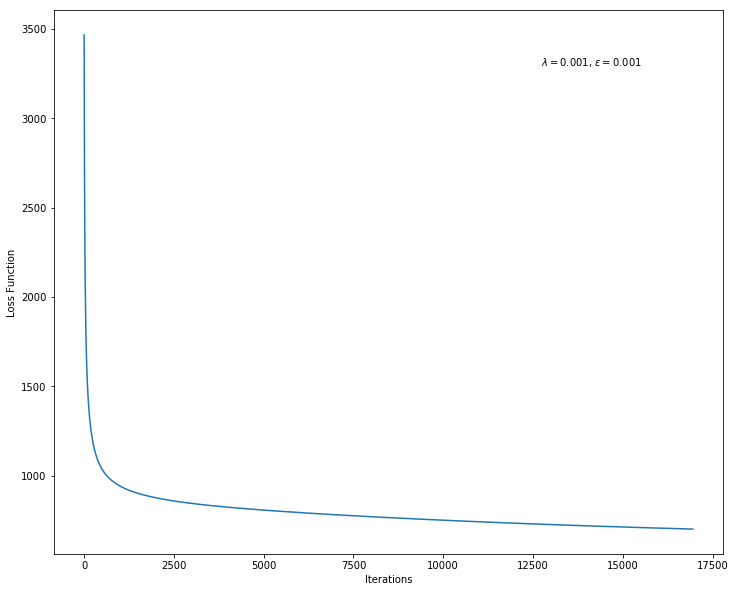

In [11]:
fig = plt.figure(figsize=(12,10))
plt.clf()

# Find the most accurate lam,eps combo
imax = np.argmax(Accs[:,0])
lam = Accs[imax,1]
eps = Accs[imax,2]

Iters = LvIs[lam][eps][0]
LossFn = LvIs[lam][eps][1]
plt.plot(Iters,LossFn)
plt.xlabel('Iterations')
plt.ylabel('Loss Function')
plt.text(0.75*np.amax(Iters),0.95*np.amax(LossFn),'$\lambda = $'+str(lam)+', $\epsilon = $'+str(eps))
plt.show()
